In [1]:
using Pkg
for p in ("BenchmarkTools","Plots","PyCall","Conda")
    haskey(Pkg.installed(),p) || Pkg.add(p)
end

# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [2]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)
a'

1×10000000 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.111411  0.839948  0.617345  0.475026  0.3133  0.937679  0.601072  0.124646  …  0.8939  0.201362  0.366847  0.15973  0.301034  0.685547  0.775253

In [3]:
sum(a)

4.998482860591541e6

The expected result is 5 * 10^6, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [4]:
@time sum(a)

@time sum(a)

@time sum(a)

  0.010294 seconds (5 allocations: 176 bytes)
  0.014735 seconds (5 allocations: 176 bytes)
  0.009886 seconds (5 allocations: 176 bytes)


4.998482860591541e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [5]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [6]:
using Libdl

C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file
# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):
open(`gcc -std=c99 -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end
# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [7]:
c_sum(a)

4.998482860591413e6

In [8]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [9]:
c_sum(a) - sum(a)  

-1.2759119272232056e-7

In [10]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

In [11]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [12]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.648 ms (0.00% GC)
  median time:      13.130 ms (0.00% GC)
  mean time:        13.177 ms (0.00% GC)
  maximum time:     18.925 ms (0.00% GC)
  --------------
  samples:          379
  evals/sample:     1

In [13]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.647857 msec


In [14]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 12.6479

In [48]:
using Plots, Statistics
default(fmt = :png)

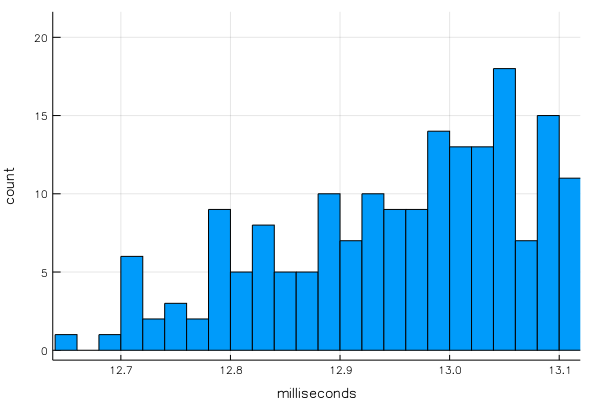

In [49]:
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [17]:
using PyCall

In [18]:
# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [19]:
pysum(a)

4.998482860591413e6

In [20]:
pysum(a) ≈ sum(a)

true

In [21]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     58.660 ms (0.00% GC)
  median time:      59.572 ms (0.00% GC)
  mean time:        60.040 ms (0.00% GC)
  maximum time:     66.299 ms (0.00% GC)
  --------------
  samples:          84
  evals/sample:     1

In [22]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 12.6479
  "Python built-in" => 58.6601

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [23]:
using Conda

In [24]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

PyObject array([0.11141075, 0.83994835, 0.61734512, ..., 0.30103384, 0.6855473 ,
       0.77525253])

In [25]:
numpy_sum(apy_list) # python thing

4.998482860591544e6

In [26]:
py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     9.640 ms (0.00% GC)
  median time:      10.098 ms (0.00% GC)
  mean time:        10.209 ms (0.00% GC)
  maximum time:     16.013 ms (0.00% GC)
  --------------
  samples:          489
  evals/sample:     1

In [27]:
numpy_sum(apy_list) ≈ sum(a)

true

In [28]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 12.6479
  "Python numpy"    => 9.63967
  "Python built-in" => 58.6601

# 4. Python, hand-written 

In [29]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f60bb617598>

In [30]:
sum_py(apy_list)

4.998482860591413e6

In [31]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     288.165 ms (0.00% GC)
  median time:      294.531 ms (0.00% GC)
  mean time:        300.066 ms (0.00% GC)
  maximum time:     384.875 ms (0.00% GC)
  --------------
  samples:          17
  evals/sample:     1

In [32]:
sum_py(apy_list) ≈ sum(a)

true

In [33]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 12.6479
  "Python numpy"        => 9.63967
  "Python hand-written" => 288.165
  "Python built-in"     => 58.6601

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [34]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:645

In [35]:
sum(a)

4.998482860591541e6

In [36]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.752 ms (0.00% GC)
  median time:      10.187 ms (0.00% GC)
  mean time:        10.322 ms (0.00% GC)
  maximum time:     16.593 ms (0.00% GC)
  --------------
  samples:          484
  evals/sample:     1

In [37]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 12.6479
  "Python numpy"        => 9.63967
  "Python hand-written" => 288.165
  "Python built-in"     => 58.6601
  "Julia built-in"      => 9.75156

# 6. Julia (hand-written) 

In [38]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [39]:
mysum(a)

4.998482860591413e6

In [40]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.948 ms (0.00% GC)
  median time:      13.645 ms (0.00% GC)
  mean time:        13.758 ms (0.00% GC)
  maximum time:     18.709 ms (0.00% GC)
  --------------
  samples:          363
  evals/sample:     1

In [41]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 12.6479
  "Python numpy"        => 9.63967
  "Julia hand-written"  => 12.9485
  "Python hand-written" => 288.165
  "Python built-in"     => 58.6601
  "Julia built-in"      => 9.75156

# 7. Julia (hand-written w. simd) 

In [42]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [43]:
mysum_simd(a)

4.998482860591543e6

In [44]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.652 ms (0.00% GC)
  median time:      9.961 ms (0.00% GC)
  mean time:        10.009 ms (0.00% GC)
  maximum time:     13.914 ms (0.00% GC)
  --------------
  samples:          499
  evals/sample:     1

In [45]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "Julia hand-written simd" => 9.65181
  "C"                       => 12.6479
  "Python numpy"            => 9.63967
  "Julia hand-written"      => 12.9485
  "Python hand-written"     => 288.165
  "Python built-in"         => 58.6601
  "Julia built-in"          => 9.75156

# Summary

In [46]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value, digits=1), 6, "."))
end

Python numpy................9.6
Julia hand-written simd.....9.7
Julia built-in..............9.8
C..........................12.6
Julia hand-written.........12.9
Python built-in............58.7
Python hand-written.......288.2
